In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import gym
from matplotlib import pyplot as plt
import itertools
from agents import *
from wrappers import *
from trainers import *
from tqdm.notebook import tqdm

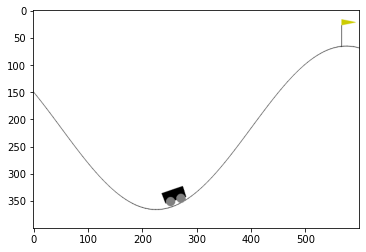

In [3]:
env = gym.make("MountainCar-v0")
state = env.reset()

frame = env.render(mode="rgb_array")
plt.imshow(frame)

[Environment page](https://gym.openai.com/envs/MountainCar-v0/)

[Environment description](https://github.com/openai/gym/wiki/MountainCar-v0)

[Environment implementation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py)

First number: position in the range from -1.2 to 0.6

Second number: velocity from -0.7 to 0.7

Actions:
* 0 - accelerate left
* 1 - don't accelerate
* 2 - accelerate right

In [4]:
state

array([-0.41404328,  0.        ], dtype=float32)

In [5]:
type(env)

gym.wrappers.time_limit.TimeLimit

In [6]:
def play_once(env: gym.Env, agent: BaseAgent, render: bool=False, verbose: bool=False) -> float:
    state = env.reset()
    episode_reward = 0.
    log = []
    for step in itertools.count():
        if render:
            env.render()
        prev_state = state
        action = agent.act(state)
        state, reward, is_done, _ = env.step(action)
        record = (reward, prev_state, action)
        log.append(record)
        episode_reward += reward
        if is_done:
            break
    if verbose:
        print('get {} rewards in {} steps'.format(
                episode_reward, step + 1))
    return episode_reward, log

In [7]:
agent = OrininalSmartAgent()
reward, _ = play_once(env, agent, render=True)
reward

-103.0

In [58]:
env = gym.make("MountainCar-v0")
discretizer = MountainCarDiscretizer(20, 20)
discrete_env = DiscreteWrapper(env, discretizer)
agent = OrininalSmartAgent()
discrete_policy = get_discrete_policy(discretizer, agent, eps=0.)

agent = DisceteSmartAgent(discretizer.n_states, discrete_policy)
reward, _ = play_once(discrete_env, agent, render=True)
reward

-85.0

In [13]:
agent = OrininalSmartAgent()
discrete_env = DiscreteWrapper(env, discretizer)
discrete_policy = get_discrete_policy(discretizer, agent, eps=0.1)
agent = DisceteSmartAgent(discretizer.n_states, discrete_policy)
reward, _ = play_once(discrete_env, agent, render=True)
reward

-119.0

In [73]:
env = gym.make("Blackjack-v1")
discretizer = BlackjackDiscretizer()
discrete_env = DiscreteWrapper(env, discretizer)
state = discrete_env.reset()
state, discretizer.restore(state)

(335, (15, 10, 0))

In [21]:
behavioral_agent = OrininalSmartAgent()
behavioral_policy = get_discrete_policy(discretizer, behavioral_agent, eps=0.1)

agent = OffPolicyMCAgent(discretizer.n_states, behavioral_policy)
discrete_env = ActionLogger(DiscreteWrapper(env, discretizer))
trainer = MCControlTrainer(gamma=1.0)

test_episodes = 100
episode_rewards = []
changed_states = set()
for episode in tqdm(range(10_000)):
    state = discrete_env.reset()
    episode_reward = 0.
    for step in itertools.count():
        action = agent.behavioral_act(state)
        state, reward, is_done, _ = discrete_env.step(action)
        episode_reward += reward
        if is_done:
            break  
    changed_states |= trainer.update(agent, discrete_env.log)
    episode_rewards.append(episode_reward)

    if episode % 1_000 == 0:
        rewards = 0.
        print(f"States changed: {len(changed_states)}")
        changed_states = set()
        for _ in range(test_episodes):
            state = discrete_env.reset()
            for step in itertools.count():
                prev_state = state
                action = agent.act(state)   
                state, reward, is_done, _ = discrete_env.step(action)
                rewards += reward
                if is_done:
                    break    
        rewards /= test_episodes
        print(f"After {episode} episodes average reward = {rewards}")
        print((np.argmax(agent.action_values, axis=1) == np.argmax(agent.behavioral_policy, axis=1)).mean())

    


  0%|          | 0/10000 [00:00<?, ?it/s]

States changed: 0
After 0 episodes average reward = -200.0
0.635
States changed: 5
After 1000 episodes average reward = -200.0
0.635
States changed: 0
After 2000 episodes average reward = -200.0
0.635
States changed: 0
After 3000 episodes average reward = -200.0
0.635
States changed: 0
After 4000 episodes average reward = -200.0
0.635
States changed: 0
After 5000 episodes average reward = -200.0
0.635
States changed: 1
After 6000 episodes average reward = -200.0
0.6325
States changed: 0
After 7000 episodes average reward = -200.0
0.6325
States changed: 1
After 8000 episodes average reward = -200.0
0.63
States changed: 0
After 9000 episodes average reward = -200.0
0.63


In [75]:
discretizer.n_states

360

In [79]:
discrete_env.action_space

TypeError: 'Discrete' object is not iterable

In [85]:
env = gym.make("Blackjack-v1")
discretizer = BlackjackDiscretizer()
discrete_env = DiscreteWrapper(env, discretizer)

behavioral_policy = np.array([[0.5, 0.5] for _ in range(discretizer.n_states)])

agent = BlackjackOffPolicyMCAgent(discretizer.n_states, behavioral_policy)
discrete_env = ActionLogger(discrete_env)
trainer = MCControlTrainer(gamma=1.0)

test_episodes = 100
episode_rewards = []
changed_states = set()
for episode in tqdm(range(10_000)):
    state = discrete_env.reset()
    episode_reward = 0.
    for step in itertools.count():
        action = agent.behavioral_act(state)
        state, reward, is_done, _ = discrete_env.step(action)
        episode_reward += reward
        if is_done:
            break  
    changed_states |= trainer.update(agent, discrete_env.log)
    episode_rewards.append(episode_reward)

    if episode % 1_000 == 0:
        rewards = 0.
        print(f"States changed: {len(changed_states)}")
        changed_states = set()
        for _ in range(test_episodes):
            state = discrete_env.reset()
            for step in itertools.count():
                prev_state = state
                action = agent.act(state)   
                state, reward, is_done, _ = discrete_env.step(action)
                rewards += reward
                if is_done:
                    break    
        rewards /= test_episodes
        print(f"After {episode} episodes average reward = {rewards}")

    


  0%|          | 0/10000 [00:00<?, ?it/s]

States changed: 1
After 0 episodes average reward = -0.22
0.9972222222222222
States changed: 98
After 1000 episodes average reward = -0.09
0.8138888888888889
States changed: 38
After 2000 episodes average reward = -0.14
0.7638888888888888
States changed: 27
After 3000 episodes average reward = -0.04
0.7694444444444445
States changed: 23
After 4000 episodes average reward = 0.08
0.7361111111111112
States changed: 17
After 5000 episodes average reward = -0.06
0.7194444444444444
States changed: 18
After 6000 episodes average reward = -0.14
0.6972222222222222
States changed: 8
After 7000 episodes average reward = 0.03
0.6944444444444444
States changed: 5
After 8000 episodes average reward = -0.13
0.6861111111111111
States changed: 7
After 9000 episodes average reward = -0.02
0.6666666666666666


In [27]:
BlackjackDiscretizer
env.reset()

(17, 2, False)

In [69]:
env = gym.make("Blackjack-v1")
pvs = set()
for _ in tqdm(range(100_000)):
    pv, dv, has_ace = env.reset()
    pvs.add(dv)
pvs

  0%|          | 0/100000 [00:00<?, ?it/s]

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [65]:
env.reset()

[autoreload of wrappers failed: Traceback (most recent call last):
  File "/Users/dmitry/opt/anaconda3/envs/week5/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/dmitry/opt/anaconda3/envs/week5/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/dmitry/opt/anaconda3/envs/week5/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/dmitry/Documents/rl_course/week5/wrappers.py", line 26, in <module>
    class BlackjackDiscretizer(BaseDiscretizer):
  File "/Users/dmitry/Documents/rl_course/week5/wrappers.py", line 32, in BlackjackDiscretizer
    Tuple(Disc

(15, 10, False)

In [28]:
state, reward, is_done, info = env.reset()

ValueError: not enough values to unpack (expected 4, got 3)

In [19]:
for state in range(400):
    if np.all(agent.action_values[state] != [1, 1, 1]):
        print(state)
        print(agent.action_values[state])
        break


0
[-43.   0.   0.]


In [28]:
agent.action_values[0]

array([-44.,   0.,   0.])

In [29]:
agent.behavioral_policy[0]

array([0.9 , 0.05, 0.05])

In [38]:
(np.argmax(agent.action_values, axis=1) == np.argmax(agent.behavioral_policy, axis=1)).mean()

0.6275

In [41]:
np.argmax(agent.action_values, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
np.argmax(agent.behavioral_policy, axis=1)

array([0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,

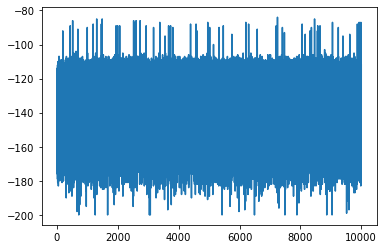

In [64]:
plt.plot(episode_rewards)